### **Figure 1: T1w/T2w similarity reflects axonal connectivity and cytoarchitectonic similarity**

MIND network edges and degrees per subject are saved to output/subj_dfs/edge_per_subj.csv and output/subj_dfs/degree_per_subj.csv

If using these, 1.2 does not need to be run

#### **1.1 Setup**

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import sys
sys.path.append('code')
from preprocessing_helpers import *
from plotting_helpers import *
from stats_helpers import *
from MIND_helpers import *

#### **1.2 Compute MIND networks**

Start by extracting T1w/T2w voxel values from pre-processed images using `extract_voxels()`

In [ ]:
# Load region lookup table
lut = pd.read_csv('data/lut_master.csv', index_col=0)

# Load subject lookup table
subj_df = pd.read_csv('data/subj_df_all.csv', index_col=0)

# Load relevant MRI directories
scan_dir = 'data/t12_img/'
label_dir = 'data/label_img/'

# Create dir to hold voxel values
vox_dir = 'output/T1wT2w/t12_vox_all/'
os.makedirs(vox_dir, exist_ok=True)

# Loop subjects, extract voxels, save
for _, row in subj_df.iterrows():
    t12_img_path = os.path.join(scan_dir, f'T1wT2w_{row["id"].astype(int).astype(str).zfill(3)}.nii')
    label_img_path = os.path.join(label_dir, f'{row["id"].astype(int).astype(str).zfill(3)}_labels.nii')
    
    vox = extract_voxels(
        t12_img_path,
        label_img_path,
        lut,
        'ROI','Side','bm_code'
    )
    
    vox.to_csv(os.path.join(vox_dir, f'T1wT2w_{row["id"].astype(int).astype(str).zfill(3)}_vox.csv'))

Now calculate MIND networks for each subject using `calculate_MIND_network()`

Additionally, extract mean T1w/T2w, network degree, and network edges per subject

In [ ]:
# Import it to iterate subjects
import itertools as it

# Ignore division by 0 errors (these are normal) 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Create dir to hold MIND networks
MIND_dir = 'output/T1wT2w/t12_MIND_all/'
os.makedirs(MIND_dir, exist_ok=True)

# Get ROIs
labs = lut['Label'].unique()
n_rois = len(labs)

# Initialise df to hold mean T1w/T2w, degree and edge values per subject
mean_t12_per_subj = np.zeros((subj_df.shape[0], n_rois))
degree_per_subj = np.zeros((subj_df.shape[0], n_rois))
edge_per_subj = np.zeros((subj_df.shape[0], int((n_rois**2-n_rois)/2)))

# Loop subjects, calculate MIND network, save
for i, row in tqdm(subj_df.iterrows()):
    vox_path = os.path.join(vox_dir, f'T1wT2w_{row["id"].astype(int).astype(str).zfill(3)}_vox.csv')
    vox_df = pd.read_csv(vox_path)

    MIND_net = calculate_mind_network(vox_df, ['Value'], labs)

    mean_t12_per_subj[i,:] = vox_df.groupby('Label', sort=False)['Value'].mean().values
    degree_per_subj[i,:] = np.sum(MIND_net, axis=0)
    edge_per_subj[i,:] = MIND_net.values[np.triu_indices(n_rois, k=1)]

    MIND_path = os.path.join(MIND_dir, f'T1wT2w_{row["id"].astype(int).astype(str).zfill(3)}_MIND.csv')
    MIND_net.to_csv(MIND_path)

# Save dataframes
mean_t12_per_subj_df = pd.concat([
    subj_df,
    pd.DataFrame(mean_t12_per_subj, columns=labs)
], axis=1)
mean_t12_per_subj_df.to_csv('output/subj_dfs/mean_t12_per_subj.csv', index=False)

degree_per_subj_df = pd.concat([
    subj_df,
    pd.DataFrame(degree_per_subj, columns=labs)
], axis=1)
degree_per_subj_df.to_csv('output/subj_dfs/degree_per_subj.csv', index=False)

edge_per_subj_df = pd.concat([
    subj_df,
    pd.DataFrame(edge_per_subj, columns=list(it.combinations(labs,2)))
], axis=1)
edge_per_subj_df.to_csv('output/subj_dfs/edge_per_subj.csv', index=False)

#### **1.3 QC MIND networks**

Remove outliers

Outliers are defined:
1. Automatically, by being in the top/bottom 1% of `global_t12` or `global_MIND`, i.e. mean T1w/T2w or degree across all regions
2. Manually, by identifying poorly registered scans

In [4]:
# Regional T1/2w
mean_t12_per_subj_df = pd.read_csv('output/subj_dfs/mean_t12_per_subj.csv', index_col=0)
mean_t12_per_subj_df = mean_t12_per_subj_df.sort_values('Age').reset_index(drop=True)

# Regional MIND
degree_per_subj_df = pd.read_csv('output/subj_dfs/degree_per_subj.csv', index_col=0)
degree_per_subj_df = degree_per_subj_df.sort_values('Age').reset_index(drop=True)

# Edge MIND
edge_per_subj_df = pd.read_csv('output/subj_dfs/edge_per_subj.csv', index_col=0)
edge_per_subj_df = edge_per_subj_df.sort_values('Age').reset_index(drop=True)

# Covariate df
covariate_per_subj_df = pd.read_csv('output/subj_dfs/covariate_per_subj.csv', index_col=0)
covariate_per_subj_df = covariate_per_subj_df.sort_values('Age').reset_index(drop=True)

# Define global measures
global_t12 = mean_t12_per_subj_df.iloc[:,4:].mean(axis=1)
global_MIND = degree_per_subj_df.iloc[:,4:].mean(axis=1)

# Generate list of indices to remove
outlier_ind = mean_t12_per_subj_df.loc[
    (global_t12 < global_t12.quantile(0.01)) |
    (global_t12 > global_t12.quantile(0.99))
].index.tolist() + degree_per_subj_df.loc[
    (global_MIND < global_MIND.quantile(0.01)) |
    (global_MIND > global_MIND.quantile(0.99))
].index.tolist()

# Add manually identified outliers to the list
outlier_sortnum = [425,128,412,410,292,358]
outlier_ind += [np.where(degree_per_subj_df['id'] == i)[0][0] for i in outlier_sortnum]
outlier_ind = np.unique(outlier_ind).tolist()

# Filter dfs to remove outliers
mean_t12_per_subj_df_filt = mean_t12_per_subj_df.drop(index=outlier_ind).reset_index(drop=True)
degree_per_subj_df_filt = degree_per_subj_df.drop(index=outlier_ind).reset_index(drop=True)
edge_per_subj_df_filt = edge_per_subj_df.drop(index=outlier_ind).reset_index(drop=True)

# Reorder covariates to match edge_dev id order
covariate_per_subj_df_filt = covariate_per_subj_df.set_index("id").reindex(edge_per_subj_df_filt["id"]).reset_index()

# Save filtered dataframes
mean_t12_per_subj_df_filt.to_csv('output/subj_dfs/mean_t12_per_subj_filt.csv')
degree_per_subj_df_filt.to_csv('output/subj_dfs/degree_per_subj_filt.csv')
edge_per_subj_df_filt.to_csv('output/subj_dfs/edge_per_subj_filt.csv')
covariate_per_subj_df_filt.to_csv('output/subj_dfs/covariate_per_subj_filt.csv')

# Mean adult T1w/T2w
mean_t12_adult = mean_t12_per_subj_df_filt[mean_t12_per_subj_df_filt['Age'] >= 1.75].iloc[:,4:].mean(axis=0)

# Save
save_dir = 'output/T1wT2w/mean/'
os.makedirs(save_dir, exist_ok=True)
mean_t12_adult.to_csv(os.path.join(save_dir, 'mean_adult_regional_t12.csv'))

Calculate mean adult MIND network, using subjects > 1.75 years, save to `/output`

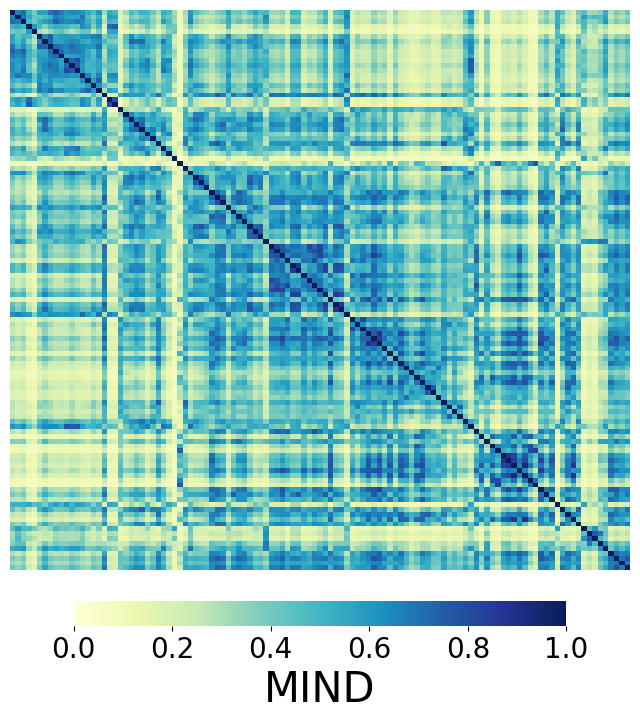

In [5]:
# Load edges
edge_per_subj_df_filt = pd.read_csv('output/subj_dfs/edge_per_subj_filt.csv', index_col=0)

# Load region lookup table, exclude APir as not in analysis
lut = pd.read_csv('data/lut_master.csv', index_col=0)
labs = lut['Label'].unique()

# Compute average MIND network
adult_edges = edge_per_subj_df_filt[edge_per_subj_df_filt['Age'] > 1.75].iloc[:,4:].mean(axis=0)
adult_MIND = np.zeros((len(labs), len(labs)))
adult_MIND[np.triu_indices(len(labs), k=1)] = adult_edges
adult_MIND += adult_MIND.T
np.fill_diagonal(adult_MIND, 1)

adult_MIND = pd.DataFrame(adult_MIND, index=labs, columns=labs)
adult_MIND.to_csv('output/T1wT2w/mean/mean_adult_t12_MIND.csv')

# Visualise average MIND network
matrix_plot(adult_MIND, 
            edge_cmap='YlGnBu', diverging=False, 
            cbar_label='MIND', 
            patches=False, boundaries=False, labels=False,
            save_path=None)

#### **1.4 Compute anatomical correlations**

Load anatomical data

In [6]:
# Load region lookup table
lut = pd.read_csv('data/lut_master.csv', index_col=0)

# Distance
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)

# Tract tracing matrix
tt = pd.read_csv('data/tract_tracing_matrix_edge_complete.csv', index_col=0)

# Mean T1w/T2w
adult_mean_t12 = pd.read_csv('output/T1wT2w/mean/mean_adult_regional_t12.csv', index_col=0)
adult_mean_t12 = adult_mean_t12[adult_mean_t12.columns[0]].values

# Load average adult MIND network
adult_MIND = pd.read_csv('output/T1wT2w/mean/mean_adult_t12_MIND.csv', index_col=0)
adult_MIND_lh = adult_MIND.iloc[0:115,0:115]

Plot correlation with distance

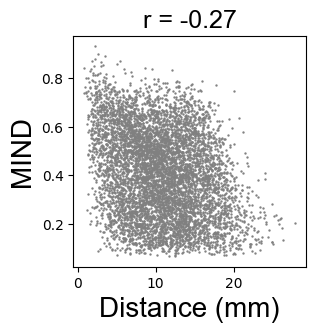

In [7]:
lh_triu_ind = np.triu_indices(adult_MIND_lh.shape[0],k=1)

to_plot = pd.DataFrame({'dist': dist.iloc[0:115,0:115].values[lh_triu_ind], 
                        'MIND': adult_MIND_lh.values[lh_triu_ind]})

plt.figure(figsize=(3,3))
plt.scatter(to_plot["dist"], to_plot["MIND"], color='grey', s=0.5)
plt.xlabel('Distance (mm)', fontsize=20, fontfamily='Arial')
plt.ylabel('MIND', fontsize=20, fontfamily='Arial')

ax = plt.gca()
x1, x2 = ax.get_xlim(); y1, y2 = ax.get_ylim()
plt.title(f'r = {spearmanr(to_plot["dist"], to_plot["MIND"])[0]:.2f}', fontsize = 18, fontfamily='Arial')
plt.show()

Plot correlation with tract tracing

BrainSmashing
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 246.22it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:00<00:00, 3926.20it/s]


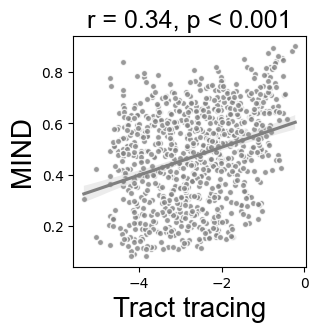

In [9]:
# Correlation with tract tracing

# Get indices to filter MIND matrix
tt_rois = tt.index.tolist()
tt_ind = lut[(lut['ROI'].isin(tt_rois)) & (lut['Side'] == 'L')].index.tolist()

r, p = get_brainsmashed_edge_correlation_p_val(mat_a = adult_MIND_lh.values, 
                                               mat_b = tt.values, 
                                               regions_ind = tt_ind, 
                                               map_a = adult_mean_t12[0:115],
                                               dist = dist.iloc[0:115,0:115].values, 
                                               surrogates_filename = 'output/surrogates/mean_adult_t12_surrogates.csv', 
                                               n_perm = 1000, 
                                               test_type = 'two-tailed')

adult_MIND_lh_filt = adult_MIND_lh.iloc[tt_ind,tt_ind]
tt_triu_ind = np.triu_indices_from(tt, k=1)

plt.figure(figsize=(3,3))
to_plot = pd.DataFrame({'tt':tt.values[tt_triu_ind], 'MIND':adult_MIND_lh_filt.values[tt_triu_ind]})
to_plot.replace([np.inf, -np.inf], np.nan, inplace=True); to_plot = to_plot.dropna() # Remove values with inf for plotting
sns.regplot(data=to_plot, x='tt', y='MIND', color='grey', scatter_kws={'s': 20, 'edgecolors':'white'})
plt.xlabel('Tract tracing', fontsize=20, fontfamily='Arial')
plt.ylabel('MIND', fontsize=20, fontfamily='Arial')
ax = plt.gca()
x1, x2 = ax.get_xlim(); y1, y2 = ax.get_ylim()
p_text = '< 0.001' if p < 0.001 else f'= {p:.3f}'
plt.title(f'r = {r:.2f}, p {p_text}', fontsize = 18, fontfamily='Arial')
plt.show()

Plot percentage of intra-class edges over a range of network densities

Calculating empirical density vs. pct intraclass curves


100%|██████████| 99/99 [00:00<00:00, 263.41it/s]


Permuting nulls
Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 241.27it/s]


Calculating null density vs. pct intraclass curves


100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


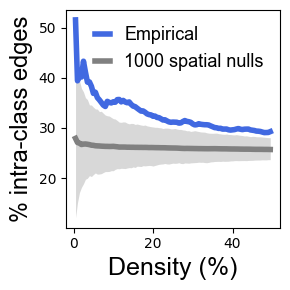

In [10]:
# Densities to loop
dens_list = np.arange(0.5, 50, 0.5)

# ----- Calculate empirical -----#
print('Calculating empirical density vs. pct intraclass curves')
emp_pct_intraclass = []

for dens in tqdm(dens_list):
    net_thresh = threshold_network(adult_MIND_lh.values, dens)
    pct_intraclass = get_pct_intraclass(net_thresh, lut['type'])
    emp_pct_intraclass.append(pct_intraclass)

# ----- Calculate  nulls -----#
n_perm = 1000

# Get null networks
print('Permuting nulls')
null_nets, _ = get_brainsmash_permuted_matrices(matrix = adult_MIND_lh.values, 
                                                map = adult_mean_t12[0:115],
                                                dist = dist.values[0:115,0:115],
                                                surrogates_filename = 'output/surrogates/mean_adult_t12_surrogates.csv', 
                                                n_perm = 1000)

nulls_pct_intraclass = np.zeros((n_perm, len(dens_list)))

# Loop null networks, calculate pct intraclass over a range of densities
print('Calculating null density vs. pct intraclass curves')
for i in tqdm(range(n_perm)):
    for j, dens in enumerate(dens_list):
        null_net_thresh = threshold_network(null_nets[i], dens)
        nulls_pct_intraclass[i,j] = get_pct_intraclass(null_net_thresh, lut['type'])

# ----- Create the plot -----#
ax = plt.figure(figsize=(3, 3))

# Get 95% confidence interval
lower = np.percentile(nulls_pct_intraclass, 2.5, axis=0) * 100
upper = np.percentile(nulls_pct_intraclass, 97.5, axis=0) * 100

# Plot
plt.plot(dens_list, np.array(emp_pct_intraclass)*100, label='Empirical', color='royalblue', linewidth=4)
plt.plot(dens_list, nulls_pct_intraclass.mean(axis=0)*100, label='1000 spatial nulls', color='gray', linewidth=4)
plt.fill_between(dens_list, lower, upper, color='gray', alpha=0.3, linewidth=0)

# Add labels and title
plt.xlabel('Density (%)', fontsize=18, fontfamily='Arial')
plt.ylabel('% intra-class edges', fontsize=17, fontfamily='Arial')
plt.yticks()
plt.legend(loc='upper right', prop={'family':'Arial', 'size':13}, frameon=False, handlelength=0.8)

# Show the plot
plt.tight_layout()
plt.show()